In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import os

from arch import arch_model
from sklearn.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA


### Data Import

In [23]:
# Define the 5 stock tickers (can be randomized later on)
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

stock_data = {}

for ticker in tickers:
    csv_filepath = f"data/{ticker}.csv"  
    try:
        df = pd.read_csv(csv_filepath, index_col="Date", parse_dates=True)
        print(f"Data loaded successfully from {csv_filepath}")
    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_filepath}. Downloading data from Yahoo Finance...")
        stock = yf.Ticker(ticker)
        hist = stock.history(start="2010-01-01", end="2025-03-07")
        df = pd.DataFrame(hist, columns=["Close"])
        df.to_csv(csv_filepath)
        print(f"Data for {ticker} downloaded and saved to {csv_filepath}")
    # Keep only the Close price
    df.rename(columns={"Close": ticker}, inplace=True)
    stock_data[ticker] = df[[ticker]]  


df_combined = pd.concat(stock_data.values(), axis=1)
df_combined.dropna(inplace=True)

print(df_combined.head())


Data loaded successfully from data/AAPL.csv
Data loaded successfully from data/MSFT.csv
Data loaded successfully from data/GOOGL.csv
Data loaded successfully from data/AMZN.csv
Data loaded successfully from data/TSLA.csv
                               AAPL       MSFT      GOOGL    AMZN      TSLA
Date                                                                       
2010-06-29 00:00:00-04:00  7.709079  17.675097  11.326808  5.4305  1.592667
2010-06-30 00:00:00-04:00  7.569441  17.447613  11.094666  5.4630  1.588667
2010-07-01 00:00:00-04:00  7.477657  17.561352  10.958523  5.5480  1.464000
2010-07-02 00:00:00-04:00  7.431316  17.644762  10.885215  5.4570  1.280000
2010-07-06 00:00:00-04:00  7.482172  18.061806  10.873248  5.5030  1.074000


### Exploratory Data Analysis

In [24]:
returns = np.log(df_combined / df_combined.shift(1)) * 100  # Multiply by 100 to express in percentage
returns.dropna(inplace=True) 

print(returns.head())

                               AAPL      MSFT     GOOGL      AMZN       TSLA
Date                                                                        
2010-06-30 00:00:00-04:00 -1.827944 -1.295384 -2.070789  0.596684  -0.251464
2010-07-01 00:00:00-04:00 -1.219971  0.649773 -1.234692  1.543942  -8.172292
2010-07-02 00:00:00-04:00 -0.621660  0.473841 -0.671206 -1.653833 -13.431235
2010-07-06 00:00:00-04:00  0.682024  2.336056 -0.109996  0.839421 -17.547006
2010-07-07 00:00:00-04:00  3.958715  1.995069  3.188897  3.016031  -1.943053


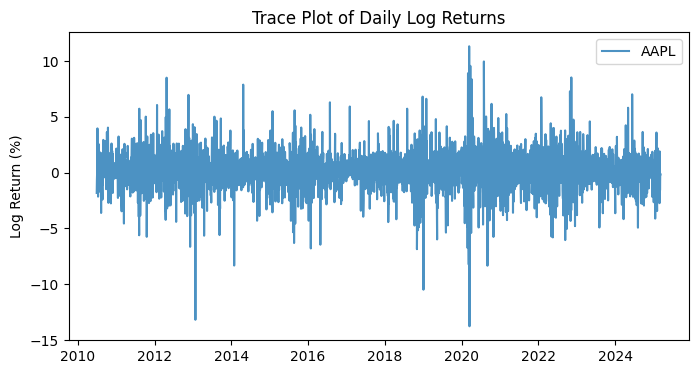

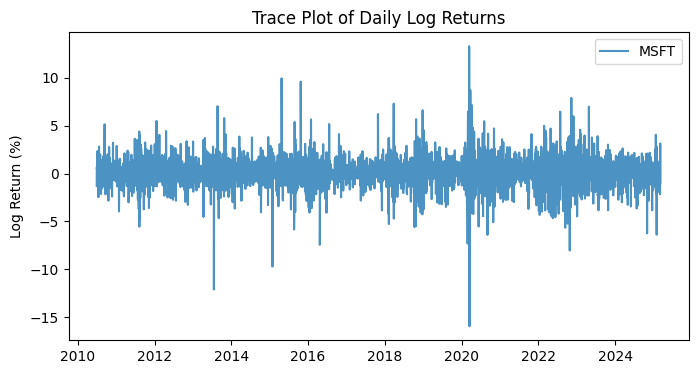

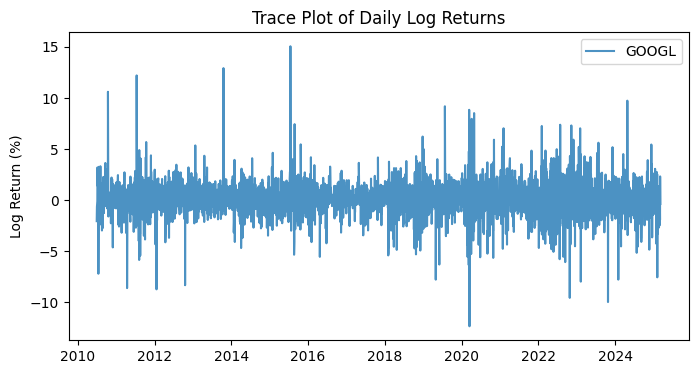

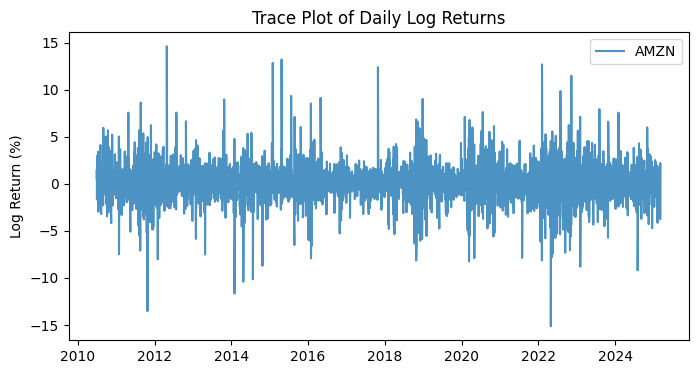

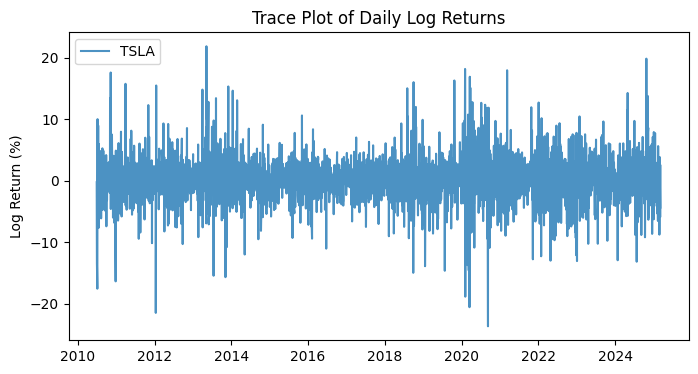

In [25]:
for ticker in returns.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(returns.index, returns[ticker], label=ticker, alpha=0.8)
    plt.title("Trace Plot of Daily Log Returns")
    plt.ylabel("Log Return (%)")
    plt.legend()
    plt.show()


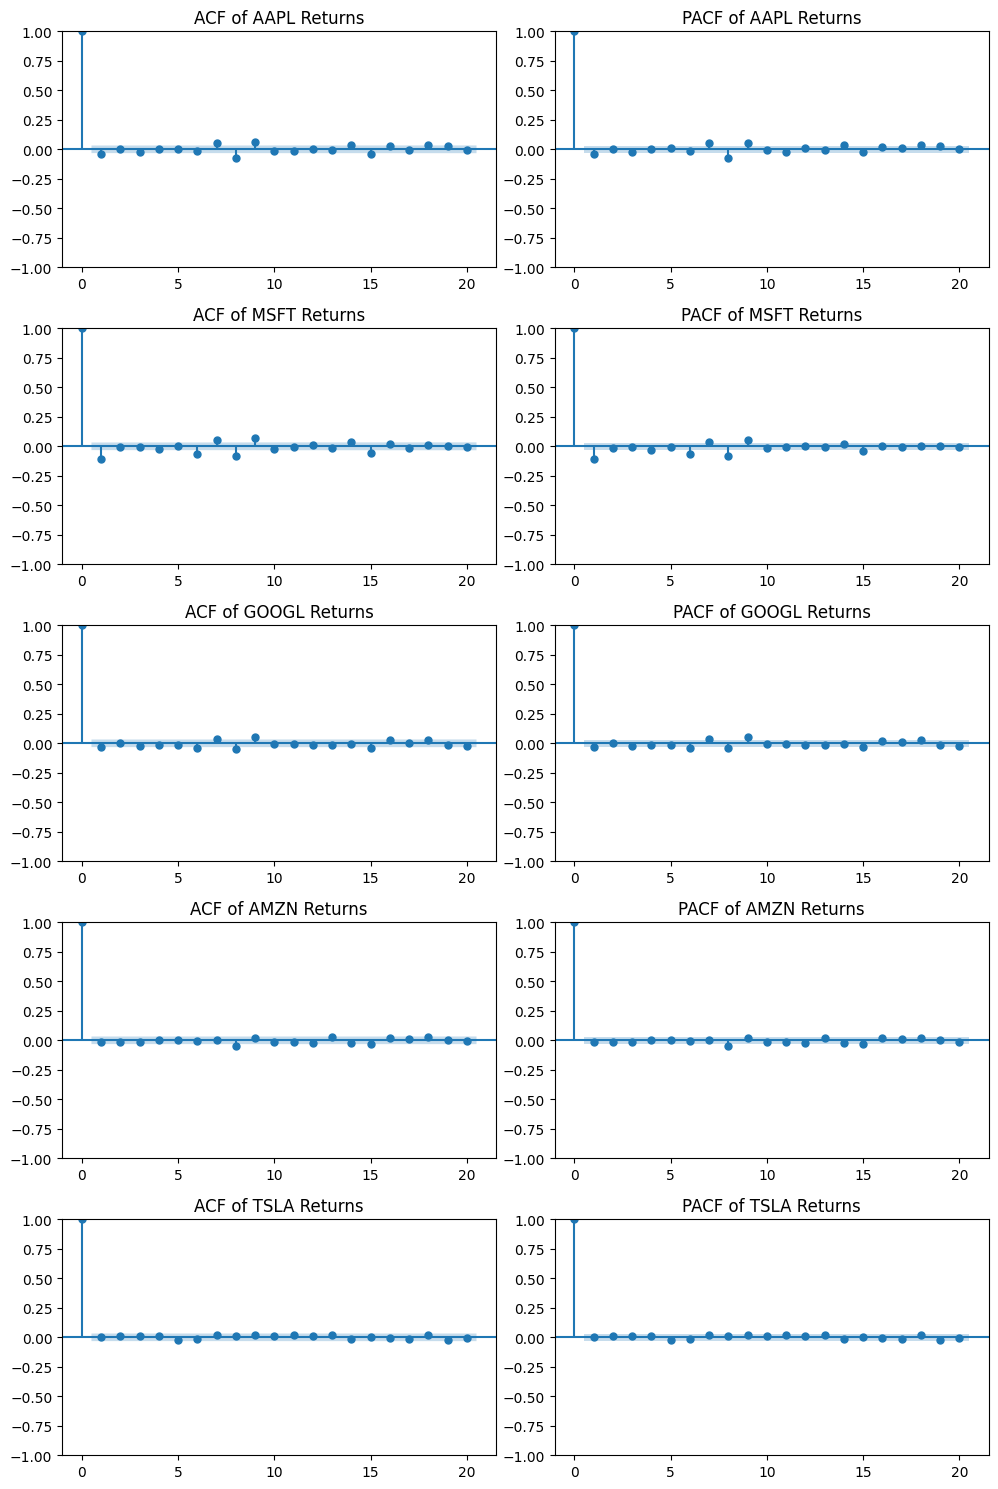

In [26]:
fig, axes = plt.subplots(len(returns.columns), 2, figsize=(10, len(returns.columns) * 3))

for i, ticker in enumerate(returns.columns):
    plot_acf(returns[ticker], ax=axes[i, 0], lags=20, title=f"ACF of {ticker} Returns")
    plot_pacf(returns[ticker], ax=axes[i, 1], lags=20, title=f"PACF of {ticker} Returns")

plt.tight_layout()
plt.show()

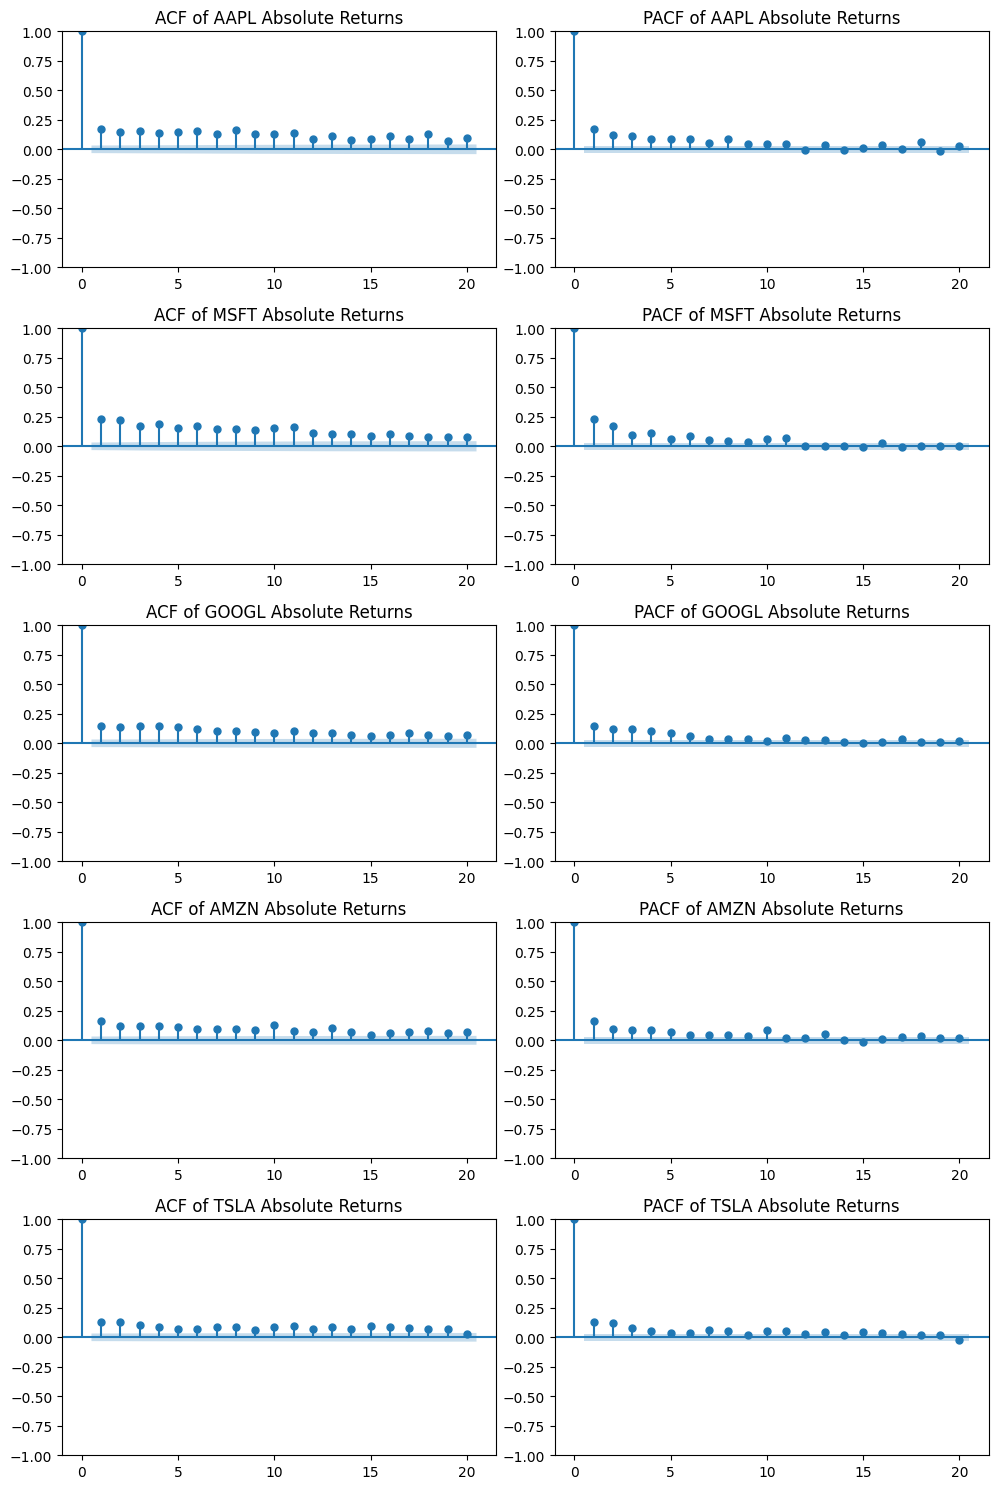

In [27]:
abs_returns = returns.abs().dropna()

fig, axes = plt.subplots(len(abs_returns.columns), 2, figsize=(10, len(abs_returns.columns) * 3))

for i, ticker in enumerate(abs_returns.columns):
    plot_acf(abs_returns[ticker], ax=axes[i, 0], lags=20, title=f"ACF of {ticker} Absolute Returns")
    plot_pacf(abs_returns[ticker], ax=axes[i, 1], lags=20, title=f"PACF of {ticker} Absolute Returns")

plt.tight_layout()
plt.show()

How to interpret: If the values in the ACF gradually decrease but stay significant, we have significant autocorrelation. This indicates volatility clustering, confirming the need for GARCH models.

### Fitting Volatility Models

In [28]:
# Reshape returns dataset into a long format
returns_long = returns.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Return')
print(returns_long.head())

returns_long = returns_long.sort_values(["Date", "Ticker"])

train_size = int(len(returns_long) * 0.8)
train_data = returns_long[:train_size]
test_data = returns_long[train_size:]

                        Date Ticker    Return
0  2010-06-30 00:00:00-04:00   AAPL -1.827944
1  2010-07-01 00:00:00-04:00   AAPL -1.219971
2  2010-07-02 00:00:00-04:00   AAPL -0.621660
3  2010-07-06 00:00:00-04:00   AAPL  0.682024
4  2010-07-07 00:00:00-04:00   AAPL  3.958715


#### GARCH(1,1)

In [29]:
garch_mod = arch_model(train_data["Return"].dropna(), vol="Garch", p=1, q=1)
garch_fit = garch_mod.fit(disp="off")

print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -31804.4
Distribution:                  Normal   AIC:                           63616.8
Method:            Maximum Likelihood   BIC:                           63647.2
                                        No. Observations:                14776
Date:                Sun, Mar 09 2025   Df Residuals:                    14775
Time:                        16:50:17   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1334  1.759e-02      7.583  3.374e-14 [9.894e-0

#### EGARCH(1,1)

In [30]:
egarch_mod = arch_model(train_data["Return"].dropna(), vol="EGarch", p=1, q=1)
egarch_fit = egarch_mod.fit(disp="off")

print(egarch_fit.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -31733.6
Distribution:                  Normal   AIC:                           63475.1
Method:            Maximum Likelihood   BIC:                           63505.5
                                        No. Observations:                14776
Date:                Sun, Mar 09 2025   Df Residuals:                    14775
Time:                        16:50:18   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1253  1.974e-02      6.347  2.202e-10 [8.660e-0